# Algoritmy Machine Learning
- využijeme připravené algoritmy knihovny `scikit-learn`
- cílem je
  - ukázat si použití jednotlivých algoritmů
  - ověřit si vliv přípravy vstupních a tréninkových dat


## Import knihoven a konstanty

In [1]:
import os
import pandas
import matplotlib.pyplot as plt

In [2]:
__file__ = __vsc_ipynb_file__  
SCRIPT_FOLDER = os.path.dirname(__file__)
PROJECT_FOLDER = os.path.dirname(SCRIPT_FOLDER)
kskore_FOLDER = os.path.join(PROJECT_FOLDER,'data')
WORK_FOLDER = os.path.join(kskore_FOLDER,'working')

PRQT = os.path.join(WORK_FOLDER,'roboti.prqt')

COL_ROBOT = 'robot'
COL_TIME = 'cas_robota'
COL_DAY = 'day'
COL_SENZOR = 'senzor'
COL_ZPRAVA = 'zprava'

COLS_KOSTKY = ['kostka1','kostka2','kostka3','kostka4','kostka5','kostka6']

def kostky_score(row):
    '''
    vypočítá skóre hodu 6 kostkami a vrátí výsledek
    Výpočet má následující pravidla:
    1. hodnotí se jen postupky začínající jedničkou /ostatní čísla nehrají roli/
    2. body za postupky jsou následující:
    | Postupka     | Body |
    |--------------|------|
    | 1-2          |  20  |
    | 1-2-3        |  30  |
    | 1-2-3-4      |  50  |
    | 1-2-3-4-5    |  90  |
    | 1-2-3-4-5-6  |  200  |
    
    Parameters
    ----------
    throw: neuspořádaný seznam hodnot kostek 
    
    Returns
    -------
    numeric
    
    '''
    throw = (row['kostka1'],row['kostka2'],row['kostka3'],row['kostka4'],row['kostka5'],row['kostka6'])
    score = 0
    ########## prostor pro splnění úkolu #########

    if len(throw) == 6 and 1 in throw and 2 in throw:
        score = 20
        if 3 in throw:
            score = 30
            if 4 in throw:
                score = 50
                if 5 in throw:
                    score = 90
                    if 6 in throw:
                        score = 200

    ##############################################
    return score



## Sada algoritmu `scikit-learn`

In [3]:
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,ExtraTreesRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier,DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.isotonic import IsotonicRegression
from sklearn.feature_extraction.text import CountVectorizer

from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect

CLASSIFIERS_MCMO = {    # Support multiclass-multioutput
	'DecisionTreeClassifier': DecisionTreeClassifier(),
	'ExtraTreeClassifier': ExtraTreeClassifier(),
	'ExtraTreesClassifier': ExtraTreesClassifier(),
	'KNeighborsClassifier': KNeighborsClassifier(3),
	#'RadiusNeighborsClassifier': RadiusNeighborsClassifier(),
	'RandomForestClassifier': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=6, random_state=42)
}

REGRESSORS = {
    'LinearRegression': LinearRegression(),
    #'IsotonicRegression': IsotonicRegression(out_of_bounds="clip"),
    'Ridge': Ridge(),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=4,weights = 'uniform'),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10),
    'ExtraTreesRegressor': ExtraTreesRegressor(max_depth=10),
	'RandomForestRegressor': RandomForestRegressor(max_depth=5, n_estimators=10, max_features=6, random_state=42)
}


c:\Users\Nikolay\Desktop\DATOVA ANALITIKA\working\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Získání zdrojových dat
### Přečtení dat robotů

In [4]:
all_robots = pandas.read_parquet(PRQT)
all_robots

cas_robota  \
robot   minute                                           
martinr 2025-10-23 21:08:00 2025-10-23 21:08:24.597380   
        2025-10-23 21:43:00 2025-10-23 21:43:30.880500   
        2025-10-23 21:44:00 2025-10-23 21:44:31.723900   
        2025-10-23 21:45:00 2025-10-23 21:45:37.731600   
        2025-10-23 21:50:00 2025-10-23 21:50:10.807800   
...                                                ...   
kucerak 2025-11-03 18:50:00 2025-11-03 18:50:59.547900   
        2025-11-03 18:52:00 2025-11-03 18:52:16.821700   
        2025-11-03 18:56:00 2025-11-03 18:56:59.056800   
        2025-11-03 18:59:00 2025-11-03 18:59:26.958900   
        2025-11-03 19:02:00 2025-11-03 19:02:32.888900   

                                                                        zprava  \
robot   minute                                                                   
martinr 2025-10-23 21:08:00                          Rip: start robotovy cesty   
        2025-10-23 21:43:00  kapsa slinta obrázek výstřel bublanina papírni...   
        2025-10-23 21:44:00  rovnátka odvaha rámus rýma modelka okno výtok ...   
        2025-10-23 21:45:00  postel odpad katapult guláš domov počasí obráz...   
        2025-10-23 21:50:00  liška šepot večírek morálka lusknutí čepice cí...   
...                                                                        ...   
kucerak 2025-11-03 18:50:00  světice vlčice hrudka úředník pošťák komín pop...   
        2025-11-03 18:52:00  přístroj záložka díra rozhodčí pomeranč cestop...   
        2025-11-03 18:56:00  úskalí pivnice chamtivost burčák výzkum tykev ...   
        2025-11-03 18:59:00  intuice zima panáček kra hřídel tyč hroch komb...   
        2025-11-03 19:02:00  trumpeta saze kostičky placatka šílenství ates...   

                                  lati      longi  kostka1  kostka2  kostka3  \
robot   minute                                                                 
martinr 2025-10-23 21:08:00  50.306888  14.289606        3        3        2   
        2025-10-23 21:43:00  50.306620  14.291078        5        5        1   
        2025-10-23 21:44:00  50.306729  14.291234        6        6        1   
        2025-10-23 21:45:00  50.306935  14.291732        3        4        2   
        2025-10-23 21:50:00  50.307039  14.291918        2        5        5   
...                                ...        ...      ...      ...      ...   
kucerak 2025-11-03 18:50:00  50.397894  14.084559        4        3        4   
        2025-11-03 18:52:00  50.397604  14.087162        1        3        5   
        2025-11-03 18:56:00  50.397556  14.088194        6        4        4   
        2025-11-03 18:59:00  50.397559  14.089010        5        1        3   
        2025-11-03 19:02:00  50.397441  14.089209        3        6        2   

                             kostka4  kostka5  kostka6      cena  pocitadlo  \
robot   minute                                                                
martinr 2025-10-23 21:08:00        3        2        2  2054.169        973   
        2025-10-23 21:43:00        1        4        2  2073.273       1859   
        2025-10-23 21:44:00        3        3        6  2036.783       2661   
        2025-10-23 21:45:00        2        2        5  2009.490       3492   
        2025-10-23 21:50:00        1        2        6  2014.313       4305   
...                              ...      ...      ...       ...        ...   
kucerak 2025-11-03 18:50:00        1        2        1    43.206    6156853   
        2025-11-03 18:52:00        4        4        3    42.700    6157924   
        2025-11-03 18:56:00        4        3        1    42.551    6158932   
        2025-11-03 18:59:00        2        2        6    43.236    6159980   
        2025-11-03 19:02:00        6        3        6    43.863    6160966   

                                  senzor         day  
robot   minute                                        
martinr 2025-10-23 21:08:00  1019.392556  2

### Extrakce dat vlastního robota

In [6]:
robot = all_robots.loc['martinr']
robot

,cas_robota,zprava,lati,longi,kostka1,kostka2,kostka3,kostka4,kostka5,kostka6,cena,pocitadlo,senzor,day
minute,,,,,,,,,,,,,,
2025-10-23 21:08:00,2025-10-23 21:08:24.597380,Rip: start robotovy cesty,50.306888,14.289606,3,3,2,3,2,2,2054.169,973,1019.392556,2025-10-23
2025-10-23 21:43:00,2025-10-23 21:43:30.880500,kapsa slinta obrázek výstřel bublanina papírni...,50.306620,14.291078,5,5,1,1,4,2,2073.273,1859,885.593550,2025-10-23
2025-10-23 21:44:00,2025-10-23 21:44:31.723900,rovnátka odvaha rámus rýma modelka okno výtok ...,50.306729,14.291234,6,6,1,3,3,6,2036.783,2661,802.114208,2025-10-23
2025-10-23 21:45:00,2025-10-23 21:45:37.731600,postel odpad katapult guláš domov počasí obráz...,50.306935,14.291732,3,4,2,2,2,5,2009.490,3492,831.269343,2025-10-23
2025-10-23 21:50:00,2025-10-23 21:50:10.807800,liška šepot večírek morálka lusknutí čepice cí...,50.307039,14.291918,2,5,5,1,2,6,2014.313,4305,813.123212,2025-10-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-03 18:51:00,2025-11-03 18:51:37.812400,pero šachovnice páteř výroba loďka šunka filtr...,50.576204,13.816847,4,1,1,1,1,6,306.742,6487109,1060.772389,2025-11-03
2025-11-03 18:56:00,2025-11-03 18:56:24.733900,trotl tkanička proton tyč káně bříza prodejce ...,50.575420,13.816016,1,5,3,1,2,4,300.761,6488076,967.151598,2025-11-03
2025-11-03 18:59:00,2025-11-03 18:59:19.494400,chamtivost savec díra pohlaví výkop facebook k...,50.575715,13.817142,4,1,6,5,4,2,296.310,6489124,1048.091093,2025-11-03


## Využití klasifikátorů
Algoritmy "s učitelem", které slouží k třídění a klasifikaci dat ...

Každý algoritmus musíme nejdříve "naučit":
1. potředujeme datovou sadu se známými výsledky
2. rozdělíme data na tréninkovou a ověřovací část
3. naučíme algoritmus na tréninkové části
4. otestujeme ho na ověřovací části a zjistíme si úspěšnost učení
5. pokud je přesnost dostatečná, můžeme algoritmus použít na data s neznámým výsledkem

### Funkce, kterou budeme používat k trénování a testování algoritmů

In [36]:
def train_classifiers(data,results):
    output = {}
    X_train, X_test, Y_train, Y_test = train_test_split(data,results,test_size=len(results)//3)
    for key,engine in CLASSIFIERS_MCMO.items():
        start = pandas.Timestamp.now()
        engine.fit(X_train,Y_train)
        step1 = pandas.Timestamp.now()
        print(f"engine `{key}` naucen za {(step1-start).total_seconds()} sec")
        result = engine.score(X_test,Y_test)
        step2 = pandas.Timestamp.now()
        print(f"engine `{key}` ma skore {result} za {(step2-step1).total_seconds()} sec")
        if result > 0.99:
            output[key] = engine
        else:
            print(f"engine`{key}` ma moc nizke skore ... ignorujeme ho")
    return output

### Hrajeme kostky
naučíme "systém" počítat skóre postupek na datech našeho robota  
=> spočítáme skore postupek "naší" známou funkcí

In [37]:
kskore = robot.apply(kostky_score,axis=1)
print("rozlozeni hodnot skore:\n",kskore.value_counts())

rozlozeni hodnot skore:
 0      7050
20     2099
30     1426
50      884
90      482
200     186
Name: count, dtype: int64


=> otestujeme algoritmy

In [38]:
train_classifiers(robot[COLS_KOSTKY],kskore)

engine `DecisionTreeClassifier` naucen za 0.012966 sec
engine `DecisionTreeClassifier` ma skore 0.793666501731816 za 0.002992 sec
engine`DecisionTreeClassifier` ma moc nizke skore ... ignorujeme ho
engine `ExtraTreeClassifier` naucen za 0.006006 sec
engine `ExtraTreeClassifier` ma skore 0.7506185056902523 za 0.002992 sec
engine`ExtraTreeClassifier` ma moc nizke skore ... ignorujeme ho
engine `ExtraTreesClassifier` naucen za 2.706363 sec
engine `ExtraTreesClassifier` ma skore 0.8723404255319149 za 0.162092 sec
engine`ExtraTreesClassifier` ma moc nizke skore ... ignorujeme ho
engine `KNeighborsClassifier` naucen za 0.053856 sec
engine `KNeighborsClassifier` ma skore 0.7201880257298368 za 0.126116 sec
engine`KNeighborsClassifier` ma moc nizke skore ... ignorujeme ho
engine `RandomForestClassifier` naucen za 0.082779 sec
engine `RandomForestClassifier` ma skore 0.6734289955467591 za 0.008977 sec
engine`RandomForestClassifier` ma moc nizke skore ... ignorujeme ho


{}

Dosažená úspěšnost není uspokojivá pokusíme se tedy upravit vstupní data do podoby vhodnější pro klasifikaci.   

### Upravíme zdrojová data použitím `Vectorizer`u
a opět je rozdělíme na tréninkovou a testovací sadu

[`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) vytvoří mapu s počtem výskytů 'tokenu' v řetězci

In [45]:
kdata = robot['kostka1'].astype(int).astype(str)\
        +robot['kostka2'].astype(int).astype(str)\
        +robot['kostka3'].astype(int).astype(str)\
        +robot['kostka4'].astype(int).astype(str)\
        +robot['kostka5'].astype(int).astype(str)\
        +robot['kostka6'].astype(int).astype(str)
        
kdata

minute
2025-10-23 21:08:00    332322
2025-10-23 21:43:00    551142
2025-10-23 21:44:00    661336
2025-10-23 21:45:00    342225
2025-10-23 21:50:00    255126
                        ...  
2025-11-03 18:51:00    411116
2025-11-03 18:56:00    153124
2025-11-03 18:59:00    416542
2025-11-03 19:01:00    536332
2025-11-03 19:03:00    224651
Length: 12127, dtype: object

In [46]:
vectorizer = CountVectorizer(token_pattern=r"\d")
x = vectorizer.fit_transform(kdata)
vectorizer.get_feature_names_out()

array(['1', '2', '3', '4', '5', '6'], dtype=object)

In [47]:
classifiers = train_classifiers(x,kskore)
classifiers.keys()

engine `DecisionTreeClassifier` naucen za 0.004986 sec
engine `DecisionTreeClassifier` ma skore 1.0 za 0.001995 sec
engine `ExtraTreeClassifier` naucen za 0.003989 sec
engine `ExtraTreeClassifier` ma skore 1.0 za 0.001995 sec
engine `ExtraTreesClassifier` naucen za 1.535058 sec
engine `ExtraTreesClassifier` ma skore 1.0 za 0.063831 sec
engine `KNeighborsClassifier` naucen za 0.000997 sec
engine `KNeighborsClassifier` ma skore 0.9987629886194953 za 1.3840379999999999 sec
engine `RandomForestClassifier` naucen za 0.037662 sec
engine `RandomForestClassifier` ma skore 0.9873824839188521 za 0.002992 sec
engine`RandomForestClassifier` ma moc nizke skore ... ignorujeme ho


dict_keys(['DecisionTreeClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'KNeighborsClassifier'])

### Použítí naučených algoritmů

In [48]:
alldata = all_robots['kostka1'].astype(int).astype(str)\
        +all_robots['kostka2'].astype(int).astype(str)\
        +all_robots['kostka3'].astype(int).astype(str)\
        +all_robots['kostka4'].astype(int).astype(str)\
        +all_robots['kostka5'].astype(int).astype(str)\
        +all_robots['kostka6'].astype(int).astype(str)
        
allx = vectorizer.transform(alldata)

In [49]:
for key,engine in classifiers.items():
    start = pandas.Timestamp.now()
    engine.predict(allx)
    print(f"engine `{key}` vse ohodnotil za {(pandas.Timestamp.now()-start).total_seconds()} sec")

engine `DecisionTreeClassifier` vse ohodnotil za 0.018949 sec
engine `ExtraTreeClassifier` vse ohodnotil za 0.012965 sec
engine `ExtraTreesClassifier` vse ohodnotil za 1.586716 sec
engine `KNeighborsClassifier` vse ohodnotil za 44.433143 sec


## Práce s textem

### 1. Příprava výsledků

In [31]:
jidlo = robot[COL_ZPRAVA].str.contains("perník|chlebíček|šunka|koláček|zelňačka|bublanina")
jidlo.value_counts()

zprava
False    10066
True      2061
Name: count, dtype: int64

### 2. Příprava dat
[`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) vytvoří mapu s počtem výskytů 'tokenu' v řetězci

In [32]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(robot[COL_ZPRAVA])
print(f"pocet nalezenych slov je:",len(vectorizer.get_feature_names_out()))
vectorizer.get_feature_names_out()

pocet nalezenych slov je: 506


array(['abstinent', 'anoda', 'anomálie', 'anonym', 'aplikace', 'armáda',
       'artefakt', 'atest', 'atletika', 'auto', 'balada', 'balonek',
       'bar', 'barvička', 'bavlna', 'beznaděj', 'bible', 'biograf',
       'bitka', 'bižuterie', 'blbost', 'bludička', 'blůza', 'bodec',
       'bodlina', 'bokovka', 'bonbon', 'bor', 'bordel', 'bouda',
       'brigádník', 'brož', 'brzda', 'bublanina', 'bufet', 'buk',
       'burčák', 'býk', 'běžec', 'břečtaň', 'bříza', 'bříško',
       'certifikát', 'cestopis', 'cesty', 'chamtivost', 'chemie',
       'chlebíček', 'chlápek', 'chrom', 'cibule', 'citrus', 'císař',
       'darebák', 'databanka', 'dekolt', 'delfín', 'demonstrace', 'deník',
       'devítka', 'deštník', 'dimenze', 'disketa', 'dlaň', 'domov',
       'dotknout', 'dovolená', 'dračice', 'drb', 'drobek', 'drzost',
       'duha', 'duplikát', 'díra', 'dítě', 'děvče', 'ekonomika', 'epocha',
       'epopej', 'estetika', 'eufórie', 'evropa', 'facebook', 'facka',
       'filtrace', 'flek', 'fyzičk

### 3. Trénování algoritmů

In [40]:
classifiers = train_classifiers(x,jidlo)

engine `DecisionTreeClassifier` naucen za 0.018951 sec
engine `DecisionTreeClassifier` ma skore 1.0 za 0.002991 sec
engine `ExtraTreeClassifier` naucen za 0.038896 sec
engine `ExtraTreeClassifier` ma skore 0.9069767441860465 za 0.042885 sec
engine`ExtraTreeClassifier` ma moc nizke skore ... ignorujeme ho
engine `ExtraTreesClassifier` naucen za 4.609128 sec
engine `ExtraTreesClassifier` ma skore 1.0 za 0.099244 sec
engine `KNeighborsClassifier` naucen za 0.000996 sec
engine `KNeighborsClassifier` ma skore 0.8401781296387927 za 0.835535 sec
engine`KNeighborsClassifier` ma moc nizke skore ... ignorujeme ho
engine `RandomForestClassifier` naucen za 0.026929 sec
engine `RandomForestClassifier` ma skore 0.830529440870856 za 0.004986 sec
engine`RandomForestClassifier` ma moc nizke skore ... ignorujeme ho


### Použití na všech robotech

### 1. Příprava výsledků

### 2. Příprava dat
[`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) vytvoří mapu s počtem výskytů 'tokenu' v řetězci

In [41]:
allx = vectorizer.transform(all_robots[COL_ZPRAVA])

### 3. Použití algoritmů

In [43]:
for key,engine in classifiers.items():
    start = pandas.Timestamp.now()
    engine.predict(allx)
    print(f"engine `{key}` vse ohodnotil za {(pandas.Timestamp.now()-start).total_seconds()} sec")

engine `DecisionTreeClassifier` vse ohodnotil za 0.017952 sec
engine `ExtraTreesClassifier` vse ohodnotil za 3.457898 sec


## Regresní algoritmy
Algoritmy, které se snaží modelovat průběh/závislosti hodnot

<Axes: >

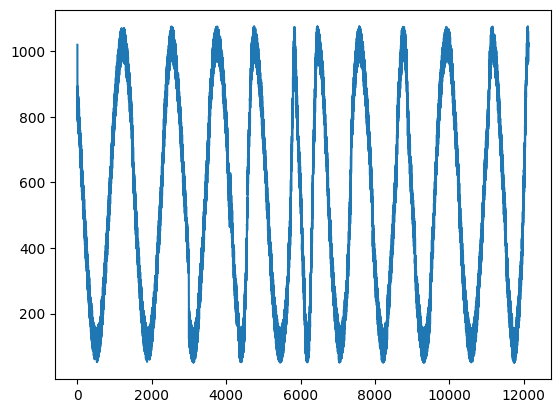

In [13]:
senzor = pandas.DataFrame(robot.sort_index().reset_index()[COL_SENZOR])
senzor.plot(legend=False)

### Příprava dat a učení algoritmů

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(senzor.index,senzor[COL_SENZOR],test_size=len(senzor)//3)

In [15]:
for key,engine in REGRESSORS.items():
        start = pandas.Timestamp.now()
        engine.fit(pandas.DataFrame(X_train),Y_train)
        step1 = pandas.Timestamp.now()
        print(f"engine `{key}` naucen za {(step1-start).total_seconds()} sec")
        result = engine.score(pandas.DataFrame(X_test),Y_test)
        step2 = pandas.Timestamp.now()
        print(f"engine `{key}` ma skore {result} za {(step2-step1).total_seconds()} sec")

engine `LinearRegression` naucen za 0.019946 sec
engine `LinearRegression` ma skore -0.0001390394444933385 za 0.001995 sec
engine `Ridge` naucen za 0.027925 sec
engine `Ridge` ma skore -0.00013903944449422667 za 0.000997 sec
engine `KNeighborsRegressor` naucen za 0.002992 sec
engine `KNeighborsRegressor` ma skore 0.987562872377631 za 0.005984 sec
engine `DecisionTreeRegressor` naucen za 0.014959 sec
engine `DecisionTreeRegressor` ma skore 0.47611751464181973 za 0.001996 sec
engine `ExtraTreesRegressor` naucen za 0.276744 sec
engine `ExtraTreesRegressor` ma skore 0.9610105376171204 za 0.061834 sec
engine `RandomForestRegressor` naucen za 0.072805 sec
engine `RandomForestRegressor` ma skore 0.24730427007363098 za 0.010971 sec


### Použití na celou datovou sadu

In [16]:
for key,engine in REGRESSORS.items():
        start = pandas.Timestamp.now()
        engine.fit(pandas.DataFrame(senzor.index),senzor[COL_SENZOR])
        step1 = pandas.Timestamp.now()
        print(f"engine `{key}` naucen za {(step1-start).total_seconds()} sec")
        senzor[key] = engine.predict(pandas.DataFrame(senzor.index))
        step2 = pandas.Timestamp.now()
        print(f"engine `{key}` probehl data za {(step1-start).total_seconds()} sec")

senzor.info()

engine `LinearRegression` naucen za 0.002992 sec
engine `LinearRegression` probehl data za 0.002992 sec
engine `Ridge` naucen za 0.001996 sec
engine `Ridge` probehl data za 0.001996 sec
engine `KNeighborsRegressor` naucen za 0.002992 sec
engine `KNeighborsRegressor` probehl data za 0.002992 sec
engine `DecisionTreeRegressor` naucen za 0.021942 sec
engine `DecisionTreeRegressor` probehl data za 0.021942 sec
engine `ExtraTreesRegressor` naucen za 0.221913 sec
engine `ExtraTreesRegressor` probehl data za 0.221913 sec
engine `RandomForestRegressor` naucen za 0.077359 sec
engine `RandomForestRegressor` probehl data za 0.077359 sec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12127 entries, 0 to 12126
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   senzor                 12127 non-null  float64
 1   LinearRegression       12127 non-null  float64
 2   Ridge                  12127 non-null  float6

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

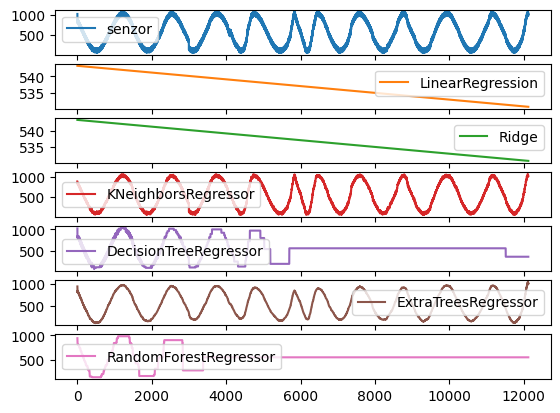

In [18]:
senzor.plot(subplots=True)

### Rozdělení na samostatné grafy
#### 1. připravíme pracovní plochu

In [19]:
senzor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12127 entries, 0 to 12126
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   senzor                 12127 non-null  float64
 1   LinearRegression       12127 non-null  float64
 2   Ridge                  12127 non-null  float64
 3   KNeighborsRegressor    12127 non-null  float64
 4   DecisionTreeRegressor  12127 non-null  float64
 5   ExtraTreesRegressor    12127 non-null  float64
 6   RandomForestRegressor  12127 non-null  float64
dtypes: float64(7)
memory usage: 663.3 KB


In [20]:
fig = plt.figure(figsize=(20,20),dpi=60)
fig_cols = 2
fig_rows = round(len(REGRESSORS)/fig_cols + 0.5)

<Figure size 1200x1200 with 0 Axes>

#### 2. vygenerujeme grafy

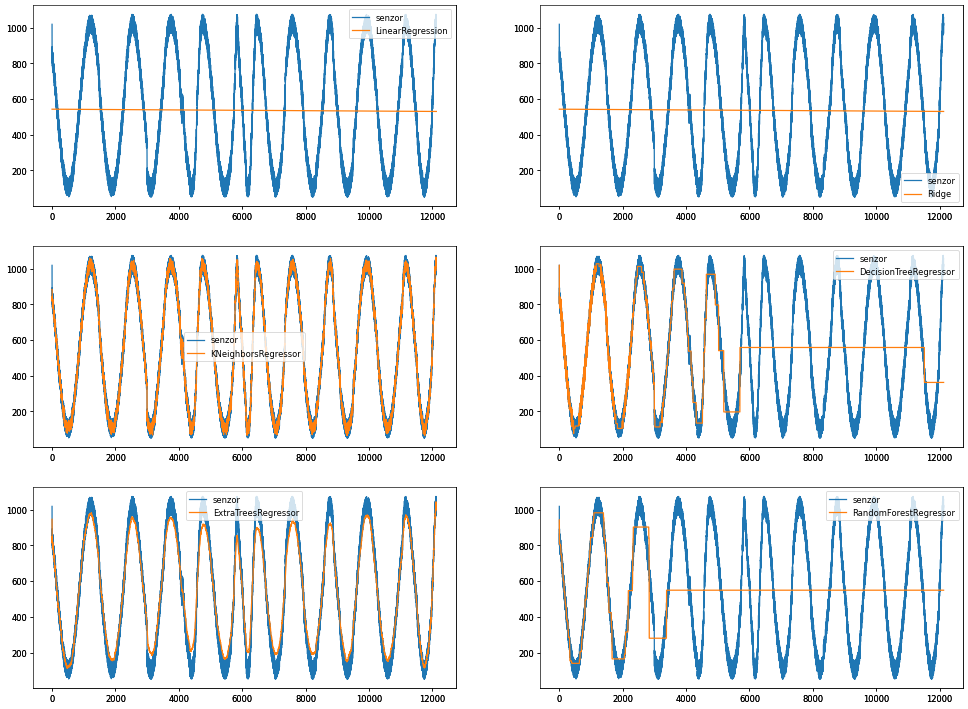

In [22]:
ii = 1
for key in REGRESSORS.keys():
    ax = fig.add_subplot(fig_rows,fig_cols,ii)
    ax.plot(senzor.index,senzor[[COL_SENZOR,key]],label=[COL_SENZOR,key])
    ax.legend()
    ii+=1
fig

## Predikce budoucnosti
použijeme `cenu robota`

<class 'pandas.core.series.Series'>
RangeIndex: 12127 entries, 0 to 12126
Series name: cena
Non-Null Count  Dtype  
--------------  -----  
12127 non-null  float64
dtypes: float64(1)
memory usage: 94.9 KB


<Axes: >

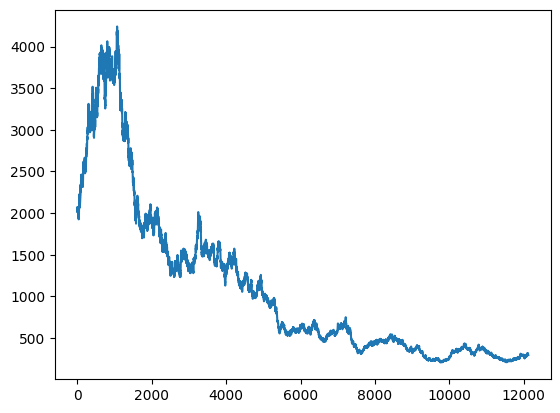

In [23]:
cena = robot.sort_index().reset_index()['cena']
cena.info()
cena.plot()

### 1. Rozdělíme data na tréninková a testovací

In [26]:
train_start = 0
train_end = len(cena) - len(cena)//10
test_end = len(cena)
train = cena.iloc[train_start:train_end]
test = cena.iloc[train_end:test_end]

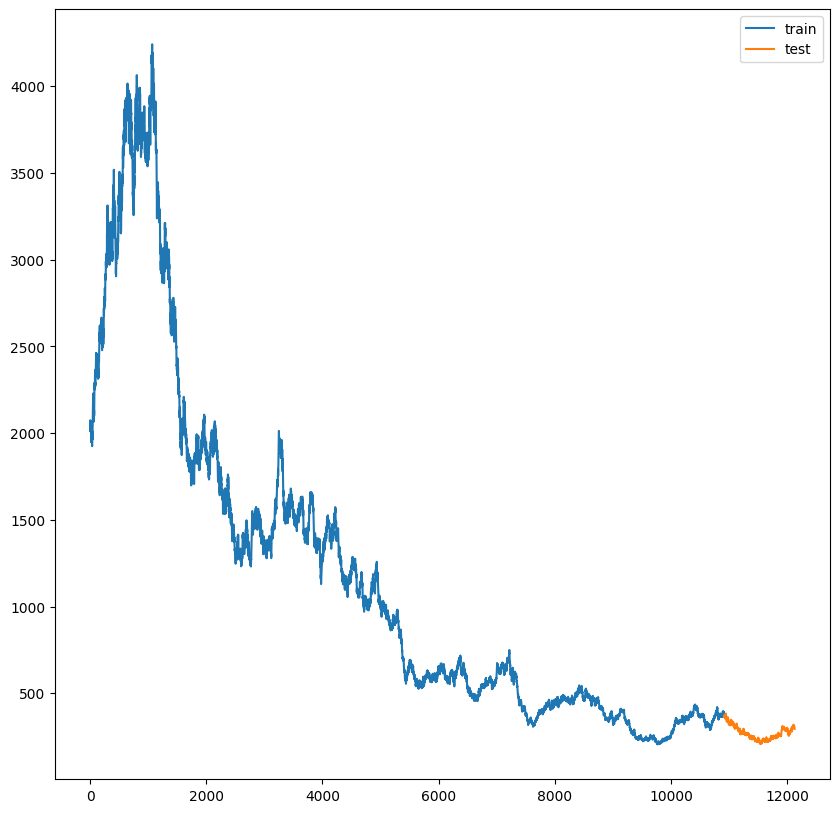

In [27]:
fig1,ax1 = plt.subplots(figsize=(10,10))
train.plot(ax=ax1,label='train')
test.plot(ax=ax1,label='test')
ax1.legend()

### 2. Připravíme si předpovídátko

In [28]:
forecaster = ForecasterRecursive(
    regressor = KNeighborsRegressor(n_neighbors=4,weights='uniform'),
    lags = 50
)

forecaster.fit(y=train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: KNeighborsRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Window features: None 
Window size: 50 
Series name: cena 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 10914] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params':
    None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'} 
fit_kwargs: {} 
Creation date: 2025-11-04 19:18:45 
Last fit date: 2025-11-04 19:18:45 
Skforecast version: 0.18.0 
Python version: 3.11.1 
Forecaster id: None

### 3. Předpovíme budoucí hodnoty

In [29]:
future = forecaster.predict(steps=2500)
future.head()

10915    371.08250
10916    372.70350
10917    376.51600
10918    380.47600
10919    380.87025
Name: pred, dtype: float64

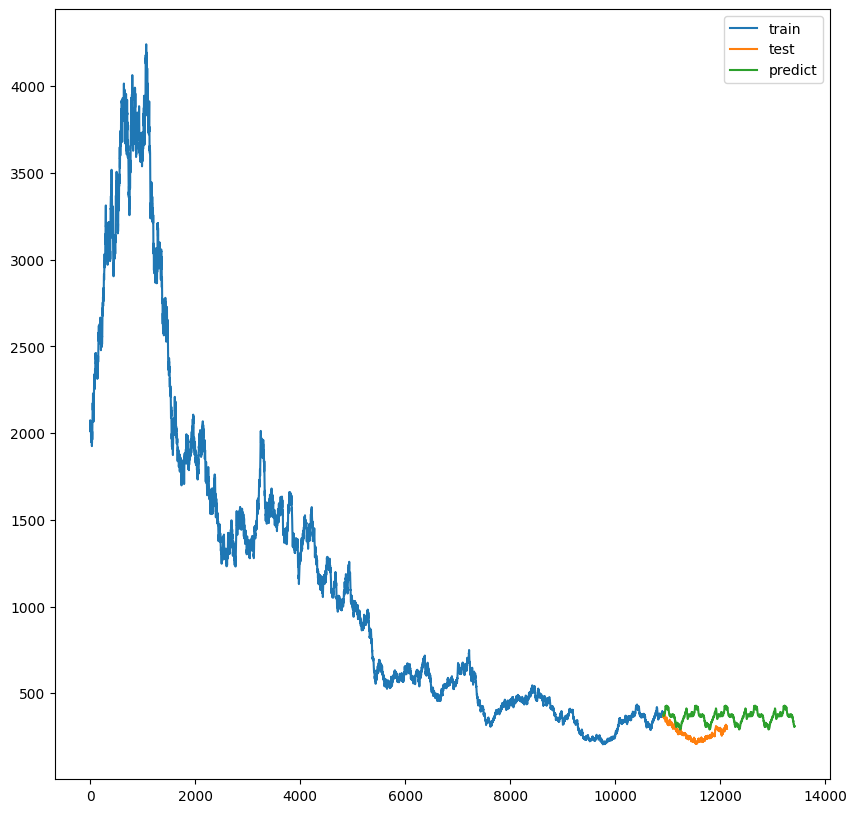

In [32]:
fig2,ax2 = plt.subplots(figsize=(10,10))
train.plot(ax=ax2,label='train')
test.plot(ax=ax2,label='test')
future.plot(ax=ax2,label='predict')
ax2.legend()